In [ ]:
# This notebook performs a statistical analysis on the psychometric performance
# of mice under optoinhibition

In [ ]:
# run this on Colab
!rm -rf APE_paper/
!git clone https://github.com/HernandoMV/APE_paper.git
%pip install git+file:///content/APE_paper
%cd APE_paper/doc/figures_notebooks

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

from APE_paper.utils import custom_functions as cuf
from APE_paper.utils.misc_utils import update_progress
from APE_paper.plot import make_figures


In [2]:
# load the dataset
dataset_path = '../../data/Optoinhibition-after-learning_dataframe.csv'
oal_df = pd.read_csv(dataset_path, index_col=0)

### Generate a dataset of random optostimulation choices
#### This is creating picking random choices, and matching trial number per session and difficulty, from trials in which there was no stimulation.

In [3]:
# Generate random optostimulation choices for every session
n_times = 1000

random_opto_df = cuf.get_random_choices_for_optostimulation(oal_df, n_times)

Progress: [####################] 100.0%


In [4]:
# Calculate the differences between the random choices and the opto ones to measure the bias

random_opto_df['bias'] = None
random_opto_df['bias_mean'] = None
random_opto_df['bias_std'] = None

for sc, session in enumerate(pd.unique(random_opto_df['SessionID'])):
    session_idx = random_opto_df.index[random_opto_df.SessionID == session].item()
    # get data for opto
    opto_df = oal_df[(oal_df['SessionID'] == session) & (oal_df['OptoStim']==1)]
    trialsDif = np.array(opto_df['TrialHighPerc'])
    sideSelected = np.array(opto_df['FirstPoke'])
    difficulty, opto_perf = cuf.get_choices(sideSelected, trialsDif)
    
    # get data for the shuffles
    updown_list = np.empty(n_times)
    for i in range(n_times):
        y_vals = random_opto_df.loc[session_idx].Random_choices[i]
        # calculate difference and normalize
        updown_list[i] = np.sum(y_vals - opto_perf) / len(difficulty)
    
    random_opto_df.at[session_idx, 'bias'] = updown_list
    random_opto_df.at[session_idx, 'bias_mean'] = np.nanmean(updown_list)
    random_opto_df.at[session_idx, 'bias_std'] = np.nanstd(updown_list)
    
    update_progress((sc + 1) / len(pd.unique(random_opto_df['SessionID'])))

Progress: [####################] 100.0%


In [5]:
# add the side in which stimulation happened, and translate the bias to contralateral / ipsilateral
random_opto_df['stimulated_side'] = None
random_opto_df['contralateral_bias'] = None

for session in pd.unique(random_opto_df['SessionID']):
    session_idx = random_opto_df.index[random_opto_df.SessionID == session].item()
    # get information
    stim_side = oal_df[oal_df['SessionID'] == session].Stimulation.unique().item()    
    # add info
    random_opto_df.at[session_idx, 'stimulated_side'] = stim_side

    # bias is the normal minus the opto. This means that a positive value is a leftwards bias of the opto trials
    # this is good as a contralateral bias for the trials in which optostimulation occurs in the right side
    # flip the sign of the ones where stimulation happens on the left
    if stim_side == 'Right':
        random_opto_df.at[session_idx, 'contralateral_bias'] = random_opto_df.at[session_idx, 'bias_mean']
    elif stim_side == 'Left':
        random_opto_df.at[session_idx, 'contralateral_bias'] = - random_opto_df.at[session_idx, 'bias_mean']
    elif stim_side == 'Both':
        random_opto_df.at[session_idx, 'contralateral_bias'] = np.nan
    else:
        print('Something wrong')

In [6]:
# Get a column with the mouse name
random_opto_df['AnimalID'] = None
# And the type of mouse
random_opto_df['Genotype'] = None

for sc, session in enumerate(pd.unique(random_opto_df['SessionID'])):
    session_idx = random_opto_df.index[random_opto_df.SessionID == session].item()    
    mouse_name = random_opto_df.loc[session_idx].SessionID.split(' ')[0]
    random_opto_df.at[session_idx, 'AnimalID'] = mouse_name
    random_opto_df.at[session_idx,'Genotype'] = mouse_name.split('-')[0]

### Generate figure 1E

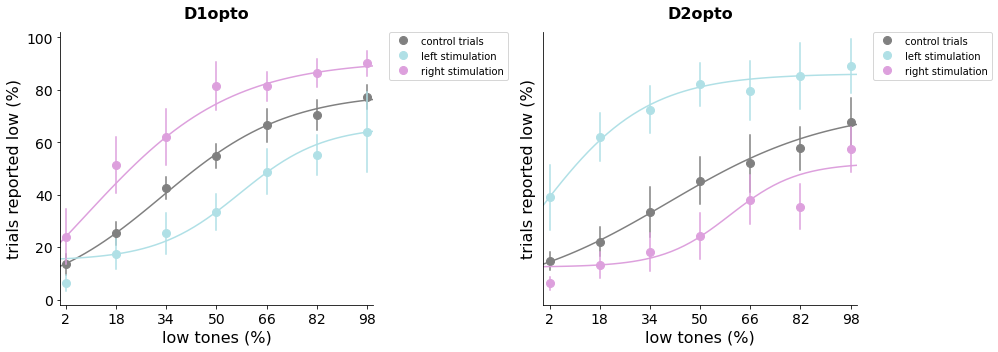

In [19]:
fig = make_figures.make_figure_optoinhibition_after_learning_curves(oal_df, random_opto_df)
plt.show(fig)
# uncomment here to save the plot
# data_directory = ''
# plt.savefig(data_directory + 'optoinhibition_after_learning_curves.pdf',
#             transparent=True, bbox_inches='tight')

#### Generate figure 1F

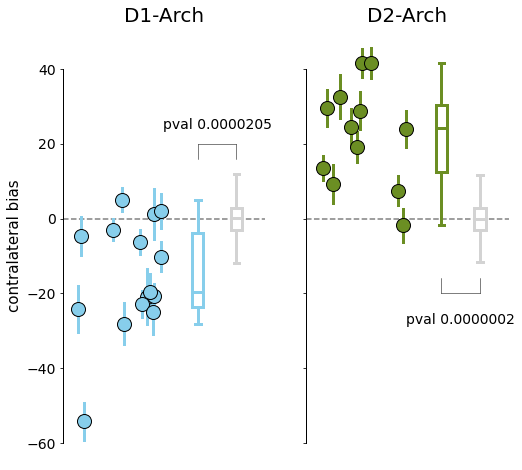

In [17]:
fig = make_figures.make_figure_optoinhibition_after_learning_batch(random_opto_df)
plt.show(fig)
# uncomment here to save the plot
# data_directory = ''
# plt.savefig(data_directory + 'optoinhibition_after_learning_batch.pdf',
#             transparent=True, bbox_inches='tight')